In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import optuna
from datetime import timedelta
from re import VERBOSE
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score

import joblib
import json
import tqdm
import shap

from hotel_preprocessing import clean_data, extract_features, drop_columns, XYPreprocessor

RANDOM_STATE = 2025
VERBOSE = 2

In [3]:
# Load and preprocess data
raw_hotel_data = pd.read_csv("hotel_bookings.csv")
hotel_data = raw_hotel_data.copy()

In [4]:
hotel_data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [5]:
# Combine year, month, and day columns into a single datetime column
hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'  # Ensure proper month name parsing
)

# Determine the latest arrival date
last_date = hotel_data['arrival_date'].max()

# Define the cutoff date for the last 3 months
cutoff_date = last_date - pd.DateOffset(months=3)

# Split by cutoff date
test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

# Separate raw features and labels
X_train_val_raw = train_val_data.drop(columns=['is_canceled'])
y_train_val_raw = train_val_data['is_canceled'].astype(int)

X_test_raw = test_data.drop(columns=['is_canceled'])
y_test_raw = test_data['is_canceled'].astype(int)

# Preprocess train_val once, then split into folds
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)

# Transform test set using the same preprocessor
X_test, y_test = preprocessor.transform(X_test_raw, y_test_raw)

In [6]:
X_train_val

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,country_binned_ITA,country_binned_NLD,country_binned_Other,country_binned_PRT,agent_binned_7.0,agent_binned_9.0,agent_binned_14.0,agent_binned_240.0,agent_binned_Not Specified,agent_binned_Other
0,0.464043,0.0,0.000000,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,1.000000,0.0,0.000000,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,0.009498,0.0,0.000000,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.017639,0.0,0.000000,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.018996,0.0,0.000000,0.000000,0.04,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103500,0.175034,1.0,1.000000,0.052632,0.08,0.036364,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
103501,0.032564,1.0,1.000000,0.105263,0.10,0.018182,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
103502,0.002714,1.0,1.000000,0.105263,0.12,0.018182,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
103503,0.051560,1.0,0.966667,0.105263,0.14,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
X_test

,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,country_binned_ITA,country_binned_NLD,country_binned_Other,country_binned_PRT,agent_binned_7.0,agent_binned_9.0,agent_binned_14.0,agent_binned_240.0,agent_binned_Not Specified,agent_binned_Other
0,0.001357,1.0,0.000000,0.000000,0.02,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
2,0.024423,1.0,0.000000,0.000000,0.04,0.036364,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,0.058345,1.0,0.000000,0.000000,0.04,0.036364,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,0.017639,1.0,0.000000,0.000000,0.06,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
5,0.025780,1.0,0.000000,0.000000,0.06,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15880,0.031208,1.0,0.966667,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
15881,0.138399,1.0,1.000000,0.105263,0.10,0.054545,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
15882,0.046133,1.0,1.000000,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
15883,0.147897,1.0,1.000000,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# Logistic Regression
def objective_lr(trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    penalty = "l2" if solver == "lbfgs" else trial.suggest_categorical("penalty", ["l1", "l2"])
    params = {
        "solver": solver,
        "penalty": penalty,
        "C": trial.suggest_float("C", 1e-3, 10.0, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "max_iter": 1000
    }

    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]

        model = LogisticRegression(**params, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)

    return np.mean(aucs)

# Run optimization
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=30)
best_params_lr = study_lr.best_params
print("Best hyperparameter for Logistic Regression:", study_lr.best_params)

[I 2025-06-28 20:19:55,119] A new study created in memory with name: no-name-0e8ee23e-371f-4016-b5b5-5777e414c456
[I 2025-06-28 20:19:56,346] Trial 0 finished with value: 0.8604623298401464 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.031489110863718285, 'class_weight': None}. Best is trial 0 with value: 0.8604623298401464.
[I 2025-06-28 20:20:05,827] Trial 1 finished with value: 0.8712729001327988 and parameters: {'solver': 'lbfgs', 'C': 0.19988319030686205, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8712729001327988.
[I 2025-06-28 20:20:07,030] Trial 2 finished with value: 0.7722098975178908 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.0011223774186093262, 'class_weight': None}. Best is trial 1 with value: 0.8712729001327988.
[I 2025-06-28 20:20:25,840] Trial 3 finished with value: 0.8769229197425759 and parameters: {'solver': 'lbfgs', 'C': 1.9634586958247588, 'class_weight': None}. Best is trial 3 with value: 0.8769229197425759.


Best hyperparameter for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 9.954930934120082, 'class_weight': 'balanced'}


In [9]:
# Define objective function for Random Forest hyperparameter tuning
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }
    
    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]
        
        model = RandomForestClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)
    
    return np.mean(aucs)

# Run optimization for Random Forest
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30)
best_params_rf = study_rf.best_params
print("Best Random Forest hyperparameters:", best_params_rf)

[I 2025-06-28 21:25:05,045] A new study created in memory with name: no-name-2525917a-9347-4784-ac85-ff0d8a1dd8c4
[I 2025-06-28 21:25:06,678] Trial 0 finished with value: 0.8635814454633641 and parameters: {'n_estimators': 98, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.8635814454633641.
[I 2025-06-28 21:25:30,225] Trial 1 finished with value: 0.9200263147682577 and parameters: {'n_estimators': 112, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9200263147682577.
[I 2025-06-28 21:25:31,674] Trial 2 finished with value: 0.8563634561800351 and parameters: {'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9200263147682577.
[I 2025-06-28 21:25:33,895] Trial 3 finished with value: 0.9046500770352921 and parameters: {'n_estimators': 88, 'max_depth': 16, 'min_sam

Best Random Forest hyperparameters: {'n_estimators': 199, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}


In [10]:
# Define objective function for Gradient Boosting hyperparameter tuning
def objective_gb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }
    
    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]
        
        model = GradientBoostingClassifier(**params, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)
    
    return np.mean(aucs)

# Run optimization for Gradient Boosting
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(objective_gb, n_trials=30)
best_params_gb = study_gb.best_params
print("Best Gradient Boosting hyperparameters:", best_params_gb)

[I 2025-06-28 21:36:55,936] A new study created in memory with name: no-name-b03125b1-1bd1-4525-87c0-d2dc46338d5e
[I 2025-06-28 21:38:36,229] Trial 0 finished with value: 0.9194197867203497 and parameters: {'n_estimators': 90, 'max_depth': 9, 'learning_rate': 0.0335197357285713, 'subsample': 0.9706253490471453, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9194197867203497.
[I 2025-06-28 21:39:36,082] Trial 1 finished with value: 0.9078667647096532 and parameters: {'n_estimators': 171, 'max_depth': 4, 'learning_rate': 0.0406482783780054, 'subsample': 0.5971733241232368, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9194197867203497.
[I 2025-06-28 21:41:06,963] Trial 2 finished with value: 0.9202070727996408 and parameters: {'n_estimators': 92, 'max_depth': 9, 'learning_rate': 0.03471477882325709, 'subsample': 0.8498283365223859, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.9202070727996408.

Best Gradient Boosting hyperparameters: {'n_estimators': 183, 'max_depth': 9, 'learning_rate': 0.05430047993564481, 'subsample': 0.8990042430808809, 'min_samples_split': 3, 'min_samples_leaf': 8}


In [11]:
# Define objective function for XGBoost tuning
def objective_xgb(trial):
    params = {
        "max_depth": trial.suggest_categorical("max_depth", [3, 6, 10]),
        "min_child_weight": trial.suggest_categorical("min_child_weight", [1, 3, 7]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.1, 0.2]),
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300, 500]),
        "reg_alpha": trial.suggest_categorical("reg_alpha", [0, 0.1, 1.0]),
        "reg_lambda": trial.suggest_categorical("reg_lambda", [1, 5, 10]),
        "subsample": trial.suggest_categorical("subsample", [0.7, 0.8, 1.0]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.7, 0.8, 1.0]),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [1, 2, 3]),
        "objective": "binary:logistic",
        "n_jobs": -1  # Use all available cores
    }
    
    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]
        
        model = XGBClassifier(**params, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)
    
    return np.mean(aucs)

# Run optimization for Gradient Boosting
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=30)
best_params_xgb = study_xgb.best_params
print("Best XGBoost hyperparameters:", best_params_xgb)

[I 2025-06-28 22:36:05,097] A new study created in memory with name: no-name-b924af8a-1369-4e7b-8783-141fe282438e
[I 2025-06-28 22:36:06,772] Trial 0 finished with value: 0.9202264090031684 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1, 'subsample': 0.8, 'colsample_bytree': 0.7, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.9202264090031684.
[I 2025-06-28 22:36:09,339] Trial 1 finished with value: 0.9147886365355754 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.1, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.9202264090031684.
[I 2025-06-28 22:36:13,396] Trial 2 finished with value: 0.8905669024912916 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.7, 'colsa

Best XGBoost hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 1}


In [12]:
# Train final models with best hyperparameters
lr_model = LogisticRegression(**best_params_lr, random_state=RANDOM_STATE)
# dt_model = DecisionTreeClassifier(**best_params_dt, random_state=RANDOM_STATE)
rf_model = RandomForestClassifier(**best_params_rf, random_state=RANDOM_STATE, n_jobs=-1)
gb_model = GradientBoostingClassifier(**best_params_gb, random_state=RANDOM_STATE)
xgb_model = XGBClassifier(**best_params_xgb, random_state=RANDOM_STATE)

In [13]:
# Fit models on the entire training set
lr_model.fit(X_train_val, y_train_val)
# dt_model.fit(X_train_val, y_train_val)
rf_model.fit(X_train_val, y_train_val)
gb_model.fit(X_train_val, y_train_val)
xgb_model.fit(X_train_val, y_train_val)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [38]:
# Define the stacking ensemble
estimators = [
    ('lr', LogisticRegression(**best_params_lr, random_state=RANDOM_STATE)),
    #('dt', DecisionTreeClassifier(**best_params_dt, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(**best_params_rf, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(**best_params_gb, random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(**best_params_xgb, random_state=RANDOM_STATE))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=2
)

In [40]:
# Train the stacking model
stacking_model.fit(X_train_val, y_train_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=2025, shuffle=True),
                   estimators=[('lr',
                                LogisticRegression(C=9.954930934120082,
                                                   class_weight='balanced',
                                                   penalty='l1',
                                                   random_state=2025,
                                                   solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(max_depth=19,
                                                       max_features=None,
                                                       min_samples_leaf=3,
                                                       min_samples_split=4,
                                                       n_estimators=199,
                                                       n_jobs=-1,
                                                       random_sta...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(random_state=2025),
                   n_jobs=-1, verbose=2)

In [42]:
# Define the voting ensemble - averaging probabilities (soft voting)
voting_model = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(**best_params_lr, random_state=RANDOM_STATE)),
        # ('dt', DecisionTreeClassifier(**best_params_dt, random_state=RANDOM_STATE)),
        ('rf', RandomForestClassifier(**best_params_rf, random_state=RANDOM_STATE, n_jobs=-1)),
        ('gb', GradientBoostingClassifier(**best_params_gb, random_state=RANDOM_STATE)),
        ('xgb', XGBClassifier(**best_params_xgb, random_state=RANDOM_STATE))
    ],
    voting='soft',
    n_jobs=-1
)

In [44]:
# Train the voting model
voting_model.fit(X_train_val, y_train_val)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=9.954930934120082,
                                                 class_weight='balanced',
                                                 penalty='l1',
                                                 random_state=2025,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(max_depth=19,
                                                     max_features=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     n_estimators=199,
                                                     n_jobs=-1,
                                                     random_state=2025)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05430...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 n_jobs=-1, voting='soft')

In [46]:
# Set the decision threshold
DECISION_THRESHOLD = 0.5

In [48]:
# Evaluate models on test set
#y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

#y_pred_dt = dt_model.predict(X_test)
# y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

#y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

#y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

#y_pred_stack = stacking_model.predict(X_test)
y_pred_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

#y_pred_vote = voting_model.predict(X_test)
y_pred_proba_vote = voting_model.predict_proba(X_test)[:, 1]

# Convert probabilities to predictions using defined threshold
y_pred_lr = (y_pred_proba_lr >= DECISION_THRESHOLD).astype(int)
# y_pred_dt = (y_pred_proba_dt >= DECISION_THRESHOLD).astype(int)
y_pred_rf = (y_pred_proba_rf >= DECISION_THRESHOLD).astype(int)
y_pred_gb = (y_pred_proba_gb >= DECISION_THRESHOLD).astype(int)
y_pred_xgb = (y_pred_proba_xgb >= DECISION_THRESHOLD).astype(int)
y_pred_stack = (y_pred_proba_stack >= DECISION_THRESHOLD).astype(int)
y_pred_vote = (y_pred_proba_vote >= DECISION_THRESHOLD).astype(int)

In [50]:
# Print evaluation metrics
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Decision Tree ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

#print("\nDecision Tree Classification Report:")
#print(classification_report(y_test, y_pred_dt))
#print(f"Decision Tree ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print(f"Gradient Boosting ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"Gradient Boosting ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\nStacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stack))
print(f"Stacking Ensemble ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_stack):.4f}")

print("\nVoting Ensemble Classification Report:")
print(classification_report(y_test, y_pred_vote))
print(f"Voting Ensemble ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_vote):.4f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      8512
           1       0.56      0.91      0.69      4649

    accuracy                           0.71     13161
   macro avg       0.74      0.76      0.71     13161
weighted avg       0.80      0.71      0.72     13161

Decision Tree ROC AUC Score: 0.8322

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      8512
           1       0.70      0.67      0.68      4649

    accuracy                           0.78     13161
   macro avg       0.76      0.76      0.76     13161
weighted avg       0.78      0.78      0.78     13161

Random Forest ROC AUC Score: 0.8554

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      8512
           1       0.71      0.67      0.

In [64]:
# Compute permutation importance for Logistic Regression
perm_importance = permutation_importance(lr_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)

# Get top 5 features for logistic regression
lr_importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False).head(5)

print("Logistic Regression Top 5 Features:")
print(lr_importances)

Logistic Regression Top 5 Features:
                        Feature  Importance
17                lead_time_log    0.058126
98           agent_binned_Other    0.055991
92           country_binned_PRT    0.046000
14  required_car_parking_spaces    0.037307
15    total_of_special_requests    0.027908


In [66]:
# Feature Importance for Random Forest
rf_importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(5)

print("Random Forest Top 5 Features:")
print(rf_importances)

Random Forest Top 5 Features:
                      Feature  Importance
94           agent_binned_9.0    0.112645
15  total_of_special_requests    0.105786
0                   lead_time    0.074328
17              lead_time_log    0.074011
92         country_binned_PRT    0.066326


In [68]:
# Feature Importance for Gradient Boosting
gb_importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(5)

print("Gradient Boosting Top 5 Features:")
print(gb_importances)

Gradient Boosting Top 5 Features:
                      Feature  Importance
94           agent_binned_9.0    0.130937
15  total_of_special_requests    0.120153
92         country_binned_PRT    0.084437
17              lead_time_log    0.078708
21            room_type_match    0.067646


In [70]:
# Feature Importance for XGBoost
xgb_importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(5)

print("XGBoost Top 5 Features:")
print(xgb_importances)

XGBoost Top 5 Features:
                        Feature  Importance
14  required_car_parking_spaces    0.169719
21              room_type_match    0.122646
98           agent_binned_Other    0.075311
72      deposit_type_Non Refund    0.050891
93             agent_binned_7.0    0.044777


In [72]:
# Compute permutation importance for stacking model
perm_importance = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)

# Get top 5 features for stacking model
stacking_importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False).head(5)

print("Stacking Ensemble Top 5 Features:")
print(stacking_importances)

Stacking Ensemble Top 5 Features:
                        Feature  Importance
92           country_binned_PRT    0.058924
15    total_of_special_requests    0.050437
94             agent_binned_9.0    0.042193
96           agent_binned_240.0    0.037018
14  required_car_parking_spaces    0.021062


In [73]:
# Compute permutation importance for voting model
perm_importance = permutation_importance(voting_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)

# Get top 5 features for voting model
voting_importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False).head(5)

print("Voting Ensemble Top 5 Features:")
print(voting_importances)

Voting Ensemble Top 5 Features:
                        Feature  Importance
92           country_binned_PRT    0.059950
15    total_of_special_requests    0.047740
96           agent_binned_240.0    0.040848
94             agent_binned_9.0    0.039108
14  required_car_parking_spaces    0.023653


# Impact of Decision Threshold

In [76]:
# Define threshold range
thresholds = np.arange(0.1, 0.9, 0.01)

In [78]:
# Function to calculate metrics for different thresholds
def calculate_metrics_by_threshold(y_true, y_pred_proba, thresholds):
    metrics = {
        'threshold': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        metrics['threshold'].append(threshold)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
    
    return pd.DataFrame(metrics)

In [80]:
models_data = {
    'Logistic Regression': y_pred_proba_lr,
    # 'Decision Tree': y_pred_proba_dt,
    'Random Forest': y_pred_proba_rf,
    'Gradient Boosting': y_pred_proba_gb,
    'XGBoost': y_pred_proba_xgb,
    'Stacking Ensemble': y_pred_proba_stack,
    'Voting Ensemble': y_pred_proba_vote
}

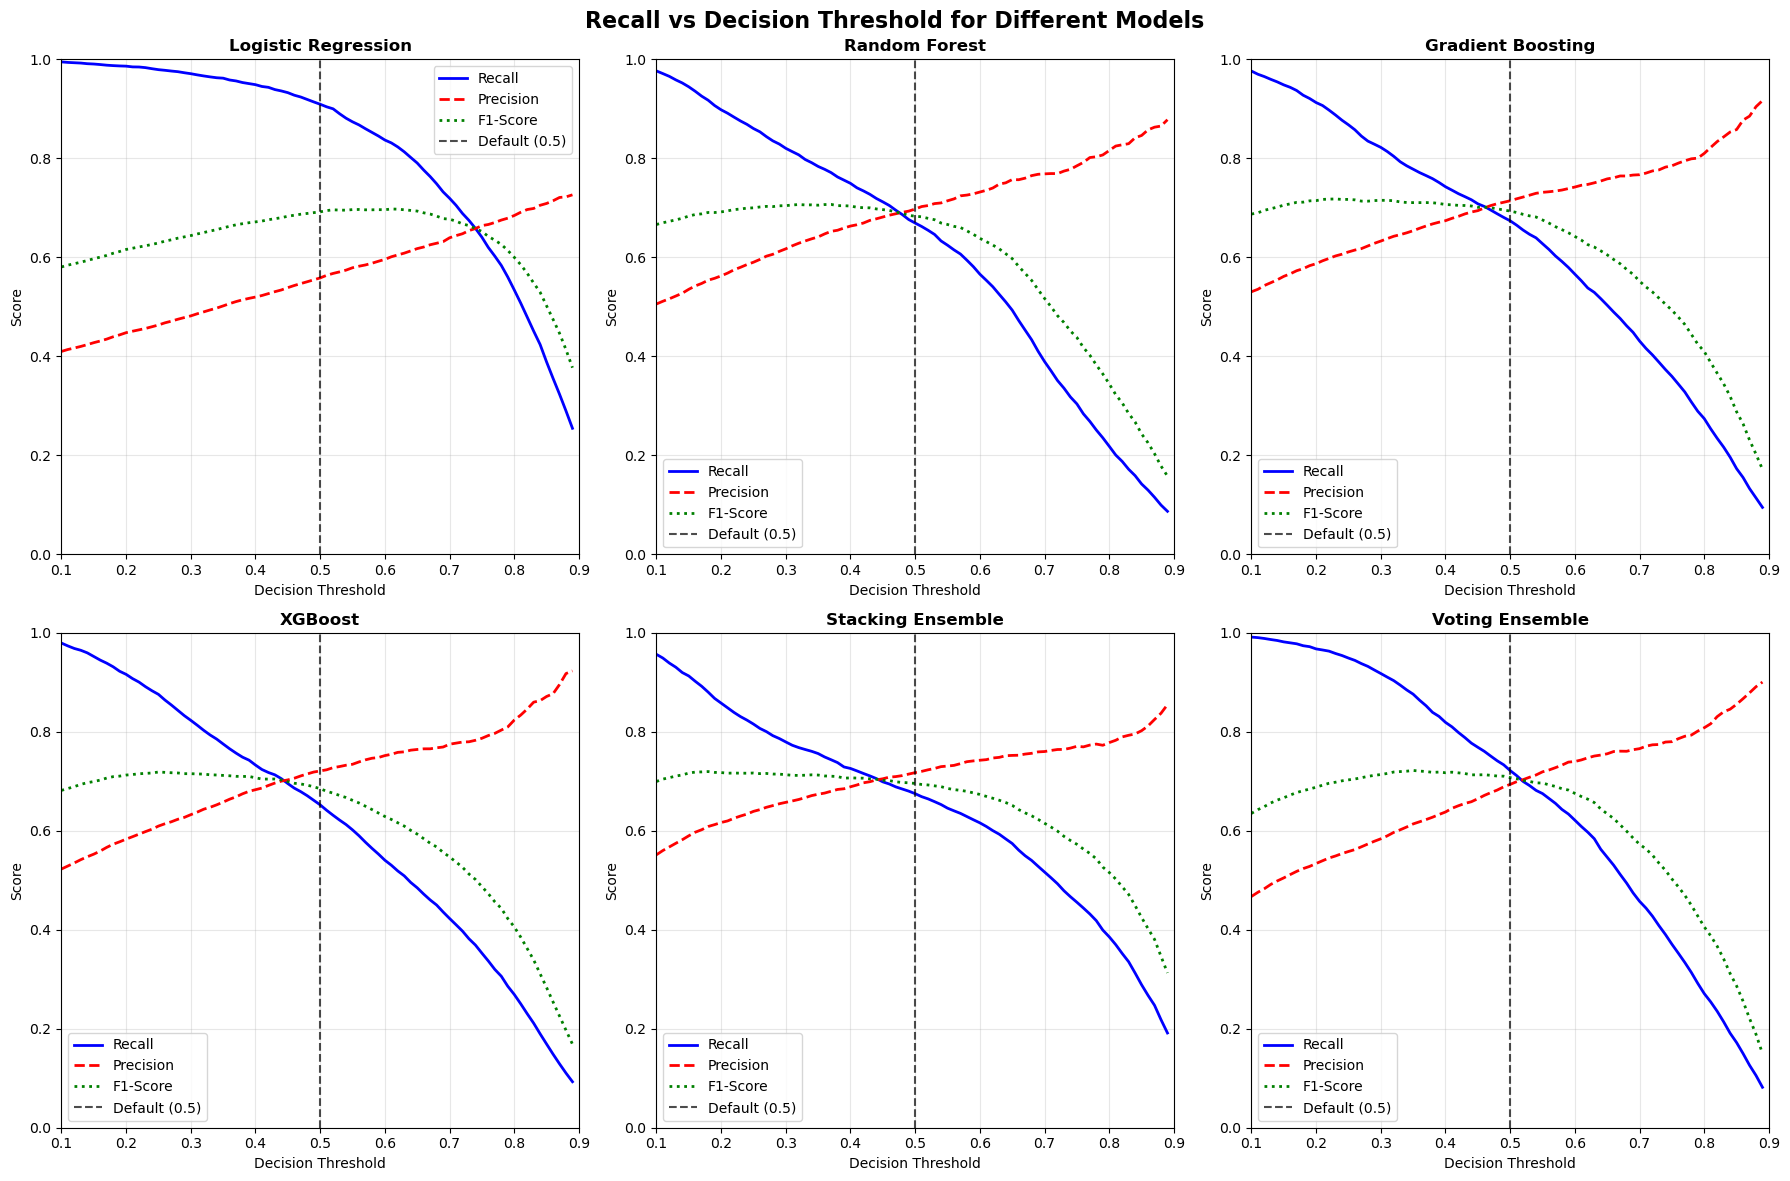

In [82]:
# Create subplots for recall vs threshold
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Recall vs Decision Threshold for Different Models', fontsize=16, fontweight='bold')

axes = axes.flatten()

model_metrics = {}
for i, (model_name, y_pred_proba) in enumerate(models_data.items()):
    # Calculate metrics
    metrics_df = calculate_metrics_by_threshold(y_test, y_pred_proba, thresholds)
    model_metrics[model_name] = metrics_df
    
    # Plot recall vs threshold
    axes[i].plot(metrics_df['threshold'], metrics_df['recall'], 'b-', linewidth=2, label='Recall')
    axes[i].plot(metrics_df['threshold'], metrics_df['precision'], 'r--', linewidth=2, label='Precision')
    axes[i].plot(metrics_df['threshold'], metrics_df['f1'], 'g:', linewidth=2, label='F1-Score')
    
    # Add vertical line at default threshold (0.5)
    axes[i].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default (0.5)')
    
    # Formatting
    axes[i].set_title(f'{model_name}', fontweight='bold')
    axes[i].set_xlabel('Decision Threshold')
    axes[i].set_ylabel('Score')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    axes[i].set_xlim(0.1, 0.9)
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [84]:
# Find optimal thresholds for different criteria
print("OPTIMAL THRESHOLDS FOR DIFFERENT CRITERIA:")
print("=" * 60)

for model_name, metrics_df in model_metrics.items():
    # Find threshold that maximizes F1 score
    best_f1_idx = metrics_df['f1'].idxmax()
    best_f1_threshold = metrics_df.loc[best_f1_idx, 'threshold']
    best_f1_score = metrics_df.loc[best_f1_idx, 'f1']
    best_f1_recall = metrics_df.loc[best_f1_idx, 'recall']
    best_f1_precision = metrics_df.loc[best_f1_idx, 'precision']
    
    # Find threshold for 80% recall
    recall_80_idx = (metrics_df['recall'] - 0.8).abs().idxmin()
    recall_80_threshold = metrics_df.loc[recall_80_idx, 'threshold']
    recall_80_precision = metrics_df.loc[recall_80_idx, 'precision']
    recall_80_f1 = metrics_df.loc[recall_80_idx, 'f1']
    
    # Find threshold for 70% recall
    recall_70_idx = (metrics_df['recall'] - 0.7).abs().idxmin()
    recall_70_threshold = metrics_df.loc[recall_70_idx, 'threshold']
    recall_70_precision = metrics_df.loc[recall_70_idx, 'precision']
    recall_70_f1 = metrics_df.loc[recall_70_idx, 'f1']
    
    print(f"\n{model_name}:")
    print(f"  Best F1 Score: Threshold = {best_f1_threshold:.3f} (F1={best_f1_score:.3f}, Recall={best_f1_recall:.3f}, Precision={best_f1_precision:.3f})")
    print(f"  For 80% Recall: Threshold = {recall_80_threshold:.3f} (Precision={recall_80_precision:.3f}, F1={recall_80_f1:.3f})")
    print(f"  For 70% Recall: Threshold = {recall_70_threshold:.3f} (Precision={recall_70_precision:.3f}, F1={recall_70_f1:.3f})")


OPTIMAL THRESHOLDS FOR DIFFERENT CRITERIA:

Logistic Regression:
  Best F1 Score: Threshold = 0.610 (F1=0.698, Recall=0.831, Precision=0.601)
  For 80% Recall: Threshold = 0.640 (Precision=0.613, F1=0.695)
  For 70% Recall: Threshold = 0.710 (Precision=0.644, F1=0.673)

Random Forest:
  Best F1 Score: Threshold = 0.370 (F1=0.707, Recall=0.771, Precision=0.652)
  For 80% Recall: Threshold = 0.330 (Precision=0.633, F1=0.706)
  For 70% Recall: Threshold = 0.460 (Precision=0.685, F1=0.695)

Gradient Boosting:
  Best F1 Score: Threshold = 0.230 (F1=0.718, Recall=0.888, Precision=0.603)
  For 80% Recall: Threshold = 0.320 (Precision=0.642, F1=0.714)
  For 70% Recall: Threshold = 0.460 (Precision=0.700, F1=0.701)

XGBoost:
  Best F1 Score: Threshold = 0.250 (F1=0.719, Recall=0.876, Precision=0.610)
  For 80% Recall: Threshold = 0.320 (Precision=0.644, F1=0.715)
  For 70% Recall: Threshold = 0.450 (Precision=0.703, F1=0.699)

Stacking Ensemble:
  Best F1 Score: Threshold = 0.180 (F1=0.720, Rec

In [86]:
# Create a comparison table of model performance at recommended threshold (0.4)
print("\nMODEL PERFORMANCE AT THRESHOLD = 0.4:")
print("=" * 60)

comparison_data = []
for model_name, y_pred_proba in models_data.items():
    y_pred_04 = (y_pred_proba >= 0.4).astype(int)
    precision_04 = precision_score(y_test, y_pred_04)
    recall_04 = recall_score(y_test, y_pred_04)
    f1_04 = f1_score(y_test, y_pred_04)
    
    comparison_data.append({
        'Model': model_name,
        'Precision': precision_04,
        'Recall': recall_04,
        'F1-Score': f1_04
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print(comparison_df.to_string(index=False, float_format='%.3f'))


MODEL PERFORMANCE AT THRESHOLD = 0.4:
              Model  Precision  Recall  F1-Score
    Voting Ensemble      0.638   0.819     0.717
            XGBoost      0.683   0.733     0.707
  Stacking Ensemble      0.689   0.726     0.707
  Gradient Boosting      0.674   0.743     0.707
      Random Forest      0.663   0.749     0.704
Logistic Regression      0.520   0.949     0.672


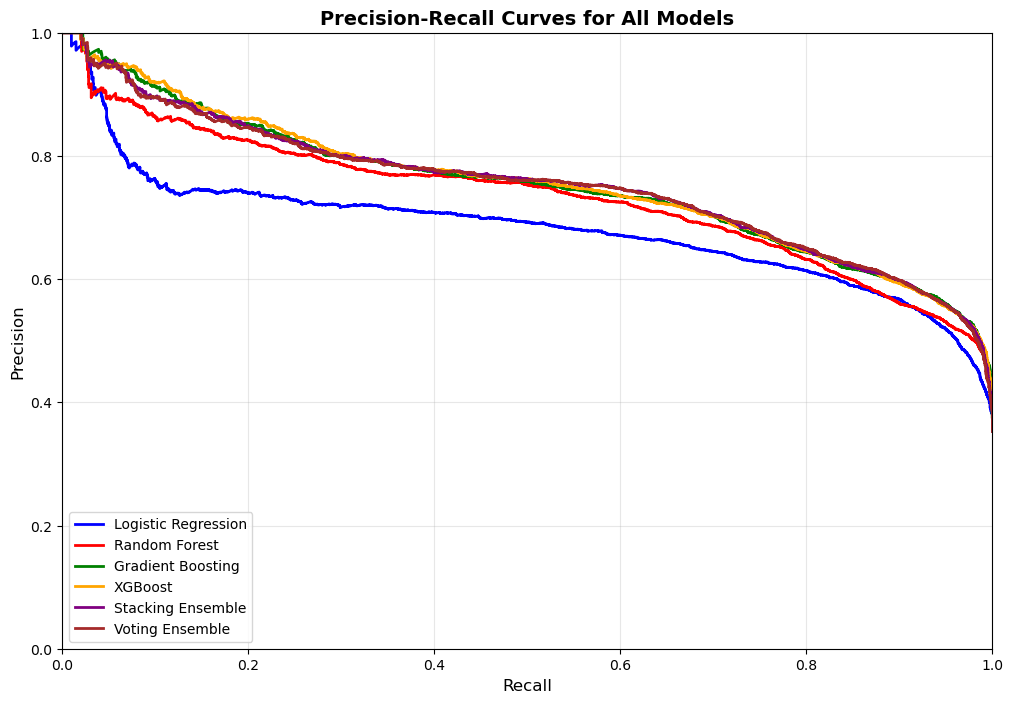

In [88]:
# Precision-Recall curves
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

for i, (model_name, y_pred_proba) in enumerate(models_data.items()):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, color=colors[i], linewidth=2, label=f'{model_name}')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves for All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()